In [1]:
import numpy as np

import typing
from typing import Any, Tuple

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pathlib

use_builtins=True

In [2]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [3]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [4]:
def load_data(path):
    text = path_to_file.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

In [5]:
targ, inp = load_data(path_to_file)
print(inp[-1])
print(targ[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [6]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [7]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Tratar de corregir a ese ni\xc3\xb1o es machacar en hierro fr\xc3\xado.'
 b'Divid\xc3\xa1monos la cuenta.'
 b'Este auto est\xc3\xa1 en buenas condiciones.'
 b'La televisi\xc3\xb3n no funciona.'
 b'Preg\xc3\xbantale al polic\xc3\xada.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Trying to correct that boy is useless.' b"Let's split the bill."
 b'This car is in good condition.' b"The TV doesn't work."
 b'Ask the policeman.'], shape=(5,), dtype=string)


In [8]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [9]:
def tf_lower_and_split_punct(text):
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [10]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [11]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(standardize = tf_lower_and_split_punct, max_tokens = max_vocab_size)


In [12]:
input_text_processor.adapt(inp)

input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']

In [13]:
output_text_processor = preprocessing.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']

In [14]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2, 1532,    6,    1,    8,   97,  208,   15,    1,   14],
       [   2,    1,   11,  265,    4,    3,    0,    0,    0,    0],
       [   2,   40,  214,   20,   14,  980, 2114,    4,    3,    0]])>

In [15]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
" ".join(tokens)

'[START] tratar de [UNK] a ese nino es [UNK] en hierro frio . [END]   '

Text(0.5, 1.0, 'Mask')

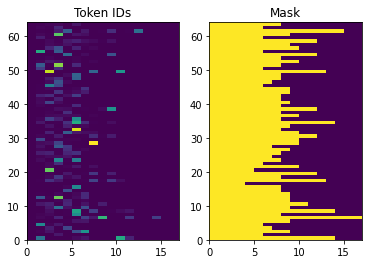

In [16]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title("Token IDs")

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens !=0)
plt.title("Mask")

In [17]:
embedding_dim = 256
units = 1024

In [18]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True, recurrent_initializer="glorot_uniform")

    def __call__(self, tokens, state=None):
        shape_checker = ShapeChecker()
        shape_checker(tokens, ('batch', 's'))

        vectors = self.embedding(tokens)
        shape_checker(vectors, ('batch', 's', 'embed_dim'))

        output, state = self.gru(vectors, initial_state=state)
        shape_checker(output, ('batch', 's', 'enc_units'))
        shape_checker(state, ('batch', 'enc_units'))

        return output, state


In [19]:
example_tokens = input_text_processor(example_input_batch)

encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

In [20]:
print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 17)
Encoder output, shape (batch, s, units): (64, 17, 1024)
Encoder state, shape (batch, units): (64, 1024)


In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()

        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()
        

    def call(self, query, value, mask):
        shape_checker = ShapeChecker()
        shape_checker(query, ('batch', 't', 'query_units'))
        shape_checker(value, ('batch', 's', 'value_units'))
        shape_checker(mask, ('batch', 's'))

        w1_query = self.W1(query)
        shape_checker(w1_query, ('batch', 't', 'attn_units'))

        w2_key = self.W2(value)
        shape_checker(w2_key, ('batch', 's', 'attn_units'))

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(inputs = [w1_query, value, w2_key], mask = [query_mask, value_mask], return_attention_scores=True)
        shape_checker(context_vector, ('batch', 't', 'value_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))

        return context_vector, attention_weights

In [34]:
attention_layer = BahdanauAttention(units)

In [35]:
(example_tokens != 0).shape


TensorShape([64, 17])

In [36]:
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

context_vector, attention_weights = attention_layer(example_attention_query, example_enc_output, (example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 17)


Text(0.5, 1.0, 'Mask')

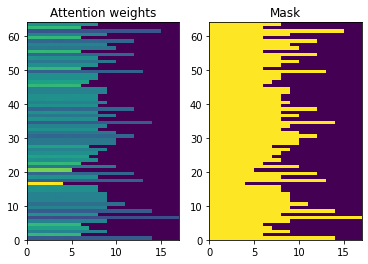

In [38]:
plt.subplot(1,2,1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1,2,2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [39]:
attention_weights.shape

TensorShape([64, 2, 17])

In [40]:
attention_slice = attention_weights[0,0].numpy()
attention_slice = attention_slice[attention_slice != 0]


<Figure size 432x288 with 0 Axes>

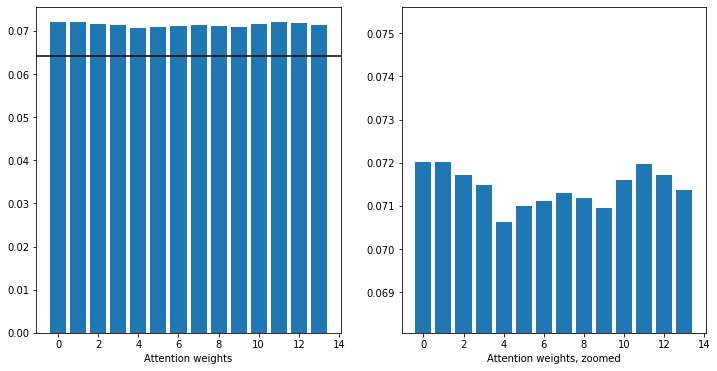

In [45]:
plt.suptitle("Attention weights for one sequence")

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1,2,1)
plt.bar(range(len(attention_slice)), attention_slice)

plt.xlim(plt.xlim())
plt.xlabel("Attention weights")

a2 = plt.subplot(1,2,2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel("Attention weights, zoomed")

top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

In [49]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size, embedding_dim)

        self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences = True, return_state=True, recurrent_initializer = 'glorot_uniform')

        self.attention = BahdanauAttention(self.dec_units)

        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh, use_bias=False)

        self.fc = tf.keras.layers.Dense(self.output_vocab_size)

    class DecoderInput(typing.NamedTuple):
        new_tokens: Any
        enc_output: Any
        mask: Any

    class DecoderOutput(typing.NamedTuple):
        logits: Any
        attention_weights: Any
    
    def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        shape_checker = ShapeChecker()
        shape_checker(inputs.new_tokens, ('batch', 't'))
        shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
        shape_checker(inputs.mask, ('batch', 's'))

        if state is not None:
            shape_checker(state, ('batch', 'dec_units'))
        vectors = self.embedding(inputs.new_tokens)
        shape_checker(vectors, ('batch', 't', 'embedding_dim'))

        rnn_output, state = self.gru(vectors, initial_state=state)

        shape_checker(rnn_output, ('batch', 't', 'dec_units'))

        shape_checker(state, ('batch', 'dec_units'))

        context_vector, attention_weights = self.attention(rnn_output, inputs.enc_output, inputs.mask)
        shape_checker(context_vector, ('batch', 't', 'dec_units'))
        shape_checker(attention_weights, ('batch', 't', 's'))
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

        attention_vector = self.Wc(context_and_rnn_output)
        shape_checker(attention_vector, ('batch', 't', 'dec_units'))

        logits = self.fc(attention_vector)
        shape_checker(logits, ('batch', 't', 'output_vocab_size'))

        return DecoderOutput(logits, attention_weights), state

In [50]:
decoder = Decoder(output_text_processor.vocabulary_size(), embedding_dim, units)

In [51]:
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]]*example_output_tokens.shape[0])

In [54]:
dec_result, dec_state = decoder(inputs = DecoderInput(new_tokens=first_token, enc_output=example_enc_output, mask = (example_tokens != 0)), state = example_enc_state)


print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [55]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)


In [56]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word

array([['saw'],
       ['hunting'],
       ['spoke'],
       ['nuts'],
       ['dollars'],
       ['water'],
       ['mans'],
       ['railroads'],
       ['proposed'],
       ['warmed'],
       ['defeated'],
       ['neat'],
       ['grades'],
       ['leather'],
       ['wheres'],
       ['gift'],
       ['elected'],
       ['even'],
       ['able'],
       ['fascinating'],
       ['decisions'],
       ['snobbish'],
       ['says'],
       ['shouldnt'],
       ['talking'],
       ['role'],
       ['breathe'],
       ['jobs'],
       ['with'],
       ['played'],
       ['arrived'],
       ['touched'],
       ['envy'],
       ['scratching'],
       ['atlantic'],
       ['lung'],
       ['dying'],
       ['books'],
       ['collect'],
       ['signs'],
       ['flood'],
       ['memory'],
       ['appalled'],
       ['knowledge'],
       ['photos'],
       ['tighten'],
       ['happen'],
       ['relaxed'],
       ['asked'],
       ['gossip'],
       ['lemonade'],
       ['shown'],
    